# PySDR: A Guide to SDR and DSP using Python
https://pysdr.org/index.html

# Mueller & Mueller Algorithm

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import math
#https://stackoverflow.com/questions/7396849/convert-binary-to-ascii-and-vice-versa

import binascii

def text_to_bits(text, encoding='utf-8', errors='surrogatepass'):
    bits = bin(int(binascii.hexlify(text.encode(encoding, errors)), 16))[2:]
    return bits.zfill(8 * ((len(bits) + 7) // 8))

def text_from_bits(bits, encoding='utf-8', errors='surrogatepass'):
    n = int(bits, 2)
    return int2bytes(n).decode(encoding, errors)

def int2bytes(i):
    hex_string = '%x' % i
    n = len(hex_string)
    return binascii.unhexlify(hex_string.zfill(n + (n & 1)))

# this part came from pulse shaping exercise
#num_symbols = 100
sps = 8 # samples per symbol
#bits_Tx = np.random.randint(0, 2, num_symbols) # Our data to be transmitted, 1's and 0's

samples = np.array([])
bits_Tx = np.array([])

text_Tx = 'Hello-World!'
bits_Tx_str = text_to_bits(text_Tx)

for i in bits_Tx_str:
    bits_Tx = np.append(bits_Tx,int(i))

for bit in bits_Tx:
    # OOK example
    pulse = bit*np.ones(sps)
    #pulse[0] = bit*2-1 # set the first value to either a 1 or -1
    samples = np.concatenate((samples, pulse)) # add the 8 samples to the signal

input_samples = samples

# Add noise
noise_amplitude = 0.1

#HIGH_level = 0.8
#LOW_level = 0.2
#samples = (HIGH_level - LOW_level) * samples
#samples = samples + LOW_level

noise = noise_amplitude*np.random.randn(len(samples))
samples = samples + noise    

noise_samples = samples

# Create and apply fractional delay filter
delay = 0.9 # fractional delay, in samples
N = 21 # number of taps
n = np.arange(-N//2, N//2) # ...-3,-2,-1,0,1,2,3...
h = np.sinc(n - delay) # calc filter taps
h *= np.hamming(N) # window the filter to make sure it decays to 0 on both sides
h /= np.sum(h) # normalize to get unity gain, we don't want to change the amplitude/power

samples = np.convolve(samples, h) # apply filter

# Include interpolation by upsampling factor
upsampling_bits = 16
downsampling_bits = 1
samples_interpolated = signal.resample_poly(samples, upsampling_bits, downsampling_bits)


In [2]:
text_from_bits(bits_Tx_str)

'Hello-World!'

In [3]:
# Mueller and Muller clock recovery technique
# https://wirelesspi.com/mueller-and-muller-timing-synchronization-algorithm/

''' The value of mu gets updated every loop iteration. It is in units of symbols, and you can think of
it as how much we have to shift by to be able to sample at the perfect time.'''

mu = 0.0 # initial estimate of phase of sample
out = np.zeros(len(samples) + 10, dtype=complex)

out_rail = np.zeros(len(samples) + 10, dtype=complex) # stores values, each iteration we need the previous 2 values plus current value

i_in = 0 # input samples index
i_out = 2 # output index (let first two outputs be 0)

while i_out < len(samples) and i_in < len(samples):
    
    out[i_out] = samples_interpolated[i_in*upsampling_bits + int(mu*upsampling_bits)]
    
    #out[i_out] = samples[i_in + int(mu)] # grab what we think is the "best" sample
    
    out_rail[i_out] = int(np.real(out[i_out]) > 0) + 1j*int(np.imag(out[i_out]) > 0)
    x = (out_rail[i_out] - out_rail[i_out-2]) * np.conj(out[i_out-1])
    y = (out[i_out] - out[i_out-2]) * np.conj(out_rail[i_out-1])
    mm_val = np.real(y - x)
    mu += sps + 0.3*mm_val
    i_in += int(np.floor(mu)) # round down to nearest int since we are using it as an index
    mu = mu - np.floor(mu) # remove the integer part of mu
    i_out += 1 # increment output index

out = out[2:i_out] # remove the first two, and anything after i_out (that was never filled out)

out = np.real(out)
#samples = out # only include this line if you want to connect this code snippet with the Costas Loop later on

print(mu)

0.6136396288293167


In [4]:
# Demodulator
threshold = 0.5
bits_Rx = np.array([])
for i in out:
    if i > threshold:
        bits_Rx = np.append(bits_Rx,1)
    if i < threshold:
        bits_Rx = np.append(bits_Rx,0)

#bits_Rx = bits_Rx[:-1]
#index = len(bits_Tx) - len(bits_Rx)       
#bits_Rx = bits_Rx[index:]

#error = out_demo - bits
#error_rate = np.sum(abs(error))/len(bits)
    
bits_Rx_str = ''
for i in bits_Rx:
    bits_Rx_str = bits_Rx_str + str(int(i))

print(len(bits_Tx_str))
print(bits_Tx_str)
print(len(bits_Rx_str))
print(bits_Rx_str)
#bits_Rx_str = bits_Rx_str[:-1]

#print(text_from_bits(bits_Tx_str))
#print(text_from_bits(bits_Rx_str))

#bits_Rx_msg = removeString(bits_Rx_str, 0, findString(bits_Rx_str,text_to_bits('xxx'))+len(text_to_bits('xxx')))

#print(text_from_bits(bits_Rx_msg))


96
010010000110010101101100011011000110111100101101010101110110111101110010011011000110010000100001
99
000100100001100101011011000110110001101111001011010101011101101111011100100110110001100100001000010


Text(0, 0.5, 'bits Rx')

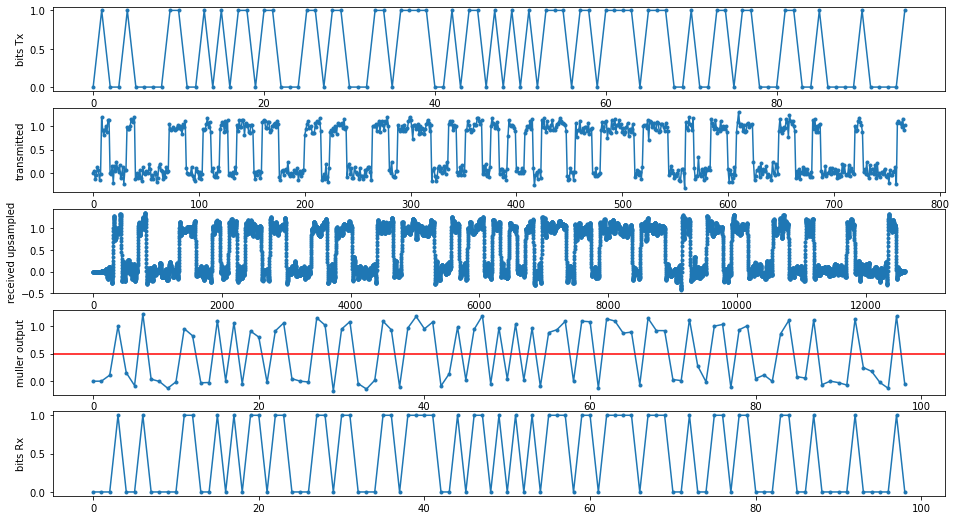

In [5]:
# Generate plots

fig, axs = plt.subplots(5,1,figsize=(16,9))
axs[0].plot(bits_Tx,'.-')
axs[0].set_ylabel('bits Tx')
axs[1].plot(noise_samples,'.-')
axs[1].set_ylabel('transmitted')
axs[2].plot(samples_interpolated,'.-')
axs[2].set_ylabel('received upsampled')
axs[3].plot(out,'.-')
axs[3].axhline(y=0.5, color='r', linestyle='-')
axs[3].set_ylabel('muller output')
axs[4].plot(bits_Rx,'.-')
axs[4].set_ylabel('bits Rx')


In [6]:
#https://stackoverflow.com/questions/7396849/convert-binary-to-ascii-and-vice-versa

import binascii

def text_to_bits(text, encoding='utf-8', errors='surrogatepass'):
    bits = bin(int(binascii.hexlify(text.encode(encoding, errors)), 16))[2:]
    return bits.zfill(8 * ((len(bits) + 7) // 8))

def text_from_bits(bits, encoding='utf-8', errors='surrogatepass'):
    n = int(bits, 2)
    return int2bytes(n).decode(encoding, errors)

def int2bytes(i):
    hex_string = '%x' % i
    n = len(hex_string)
    return binascii.unhexlify(hex_string.zfill(n + (n & 1)))

def removeString(strObj, start, stop):
    # Remove charactes from index 5 to 10
    if len(strObj) > stop :
        strObj = strObj[0: start:] + strObj[stop + 1::]
    
    return strObj

def findString(strObj,string):
    return strObj.find(string,0)

In [7]:
a = text_to_bits('hello')
a

'0110100001100101011011000110110001101111'

In [8]:
text_from_bits('110100001100101011011000110110001101111')


'hello'